# Demonstrating the effect of Feature Transformation

In [1]:
library(ggplot2)
oldw <- getOption("warn")
options(warn = -1)

## Data Synthesis

In [2]:
# generate data (use two circle boundaries to generate data from two concentric circles)
N = 2000
x1 = runif(N, -1, 1)
x2 = runif(N, -1, 1)
# subset x1 and x2 values falling within a unit circle
c = which((x2 < sqrt((1-x1^2))) & (x2 > -sqrt((1-x1^2))))
x1 = x1[c]
x2 = x2[c]

# subset from the unit circle's subset a smaller subset of points falling within a cricle of radius sqrt(0.5)
c1 = which((x2 < sqrt((0.5-x1^2))) & (x2 > -sqrt((0.5-x1^2))))

# create labels
data = data.frame(x1 = x1, x2 = x2, label = 0)
data[c1,'label'] = 'c1'
data[-c1,'label'] = 'c2'
data$label = factor(data$label)

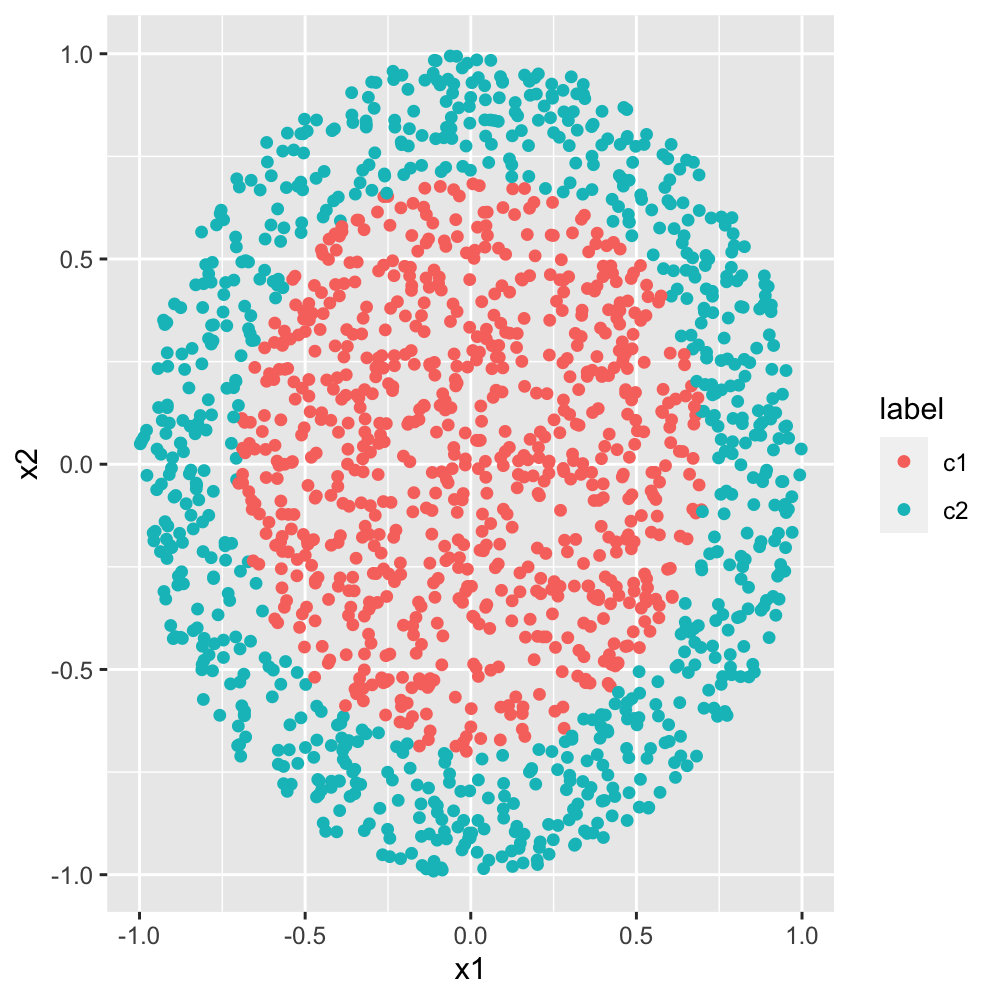

In [3]:
# plot
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 200)
ggplot(data, aes(x1, x2, color = label)) + geom_point()

## Fitting a linear classifier without feature transformation

Now let's fit a logistic regression classifier to our data

In [4]:
# some aux functions first

# function to calculate sigmoid
sigmoid <- function(x){
    1/(1+exp(-x))
}
# define function to calculate loss using X,Y and a given arbitrary parameter vector
loss <- function(X, Y, W){
Y_hat = sigmoid(X%*%W)
loglikelihood = mean(ifelse(Y == 1,log(Y_hat), log(1-Y_hat)))
-loglikelihood
}

predict <- function(W, X, ret_prob = FALSE){
    probs = sigmoid(X%*%W)
    if (!ret_prob){
        return (ifelse(probs > 0.5, 'c2','c1'))
        }
    else{
        return (probs)
    }
}

In [5]:
# creating the feature and label matrices and building the model
X = matrix(cbind(1,data$x1, data$x2), ncol = 3)
Y = matrix(ifelse(data$label == 'c1', 0, 1), ncol = 1)

W_Hat = matrix(runif(3), nrow = 3 , ncol = 1)
eta = 0.0001
epoch_max = 10000
epsilon = 0.0001
error = c()
# start gradient descent
for (k in 1:epoch_max){
    error[k] <- loss(X, Y, W_Hat)
    #grad = colSums(matrix(rep((sigmoid(X%*%W_Hat) - Y) , 3), ncol = 3) * X)
    grad = t(X) %*% (sigmoid(X%*%W_Hat) - Y)
    W_old = W_Hat
    W_Hat = W_Hat - eta * grad
    if (abs(max(W_Hat - W_old)) < epsilon){break}
    }

In [6]:
# check for convergence (k < epoch_max)
k

[1] 149

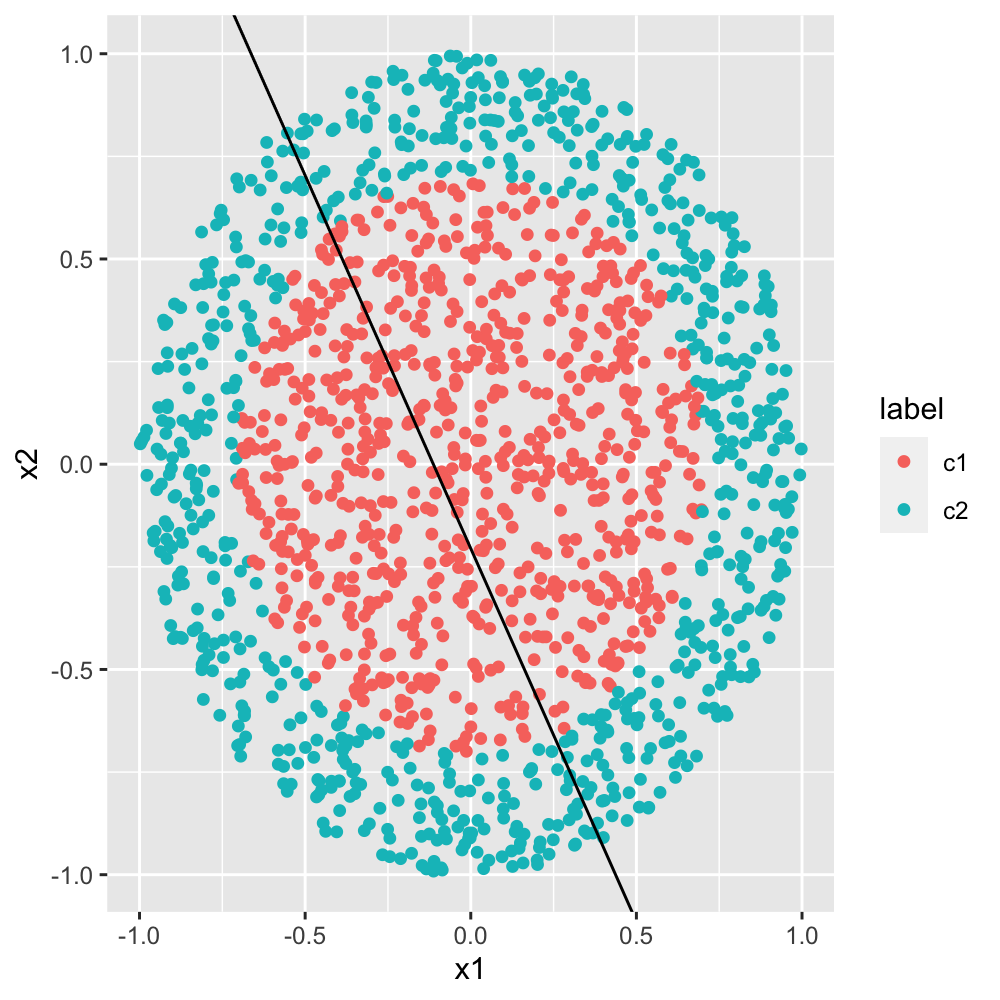

In [7]:
# plot the decision boundary
w0 = W_Hat[1]
w1 = W_Hat[2]
w2 = W_Hat[3]
ggplot(data, aes(x1, x2, color = label)) + geom_point() + geom_abline(intercept = -w0/w2, slope = -w1/w2)

In [8]:
# check accuracy
accuracy = mean(predict(W_Hat, X) == data$label)
paste('Training Accuracy without feature transformation: ', round(100*accuracy, 2), '%')

[1] "Training Accuracy without feature transformation:  48.76 %"

## Fitting a linear classifier with Feature Transformation

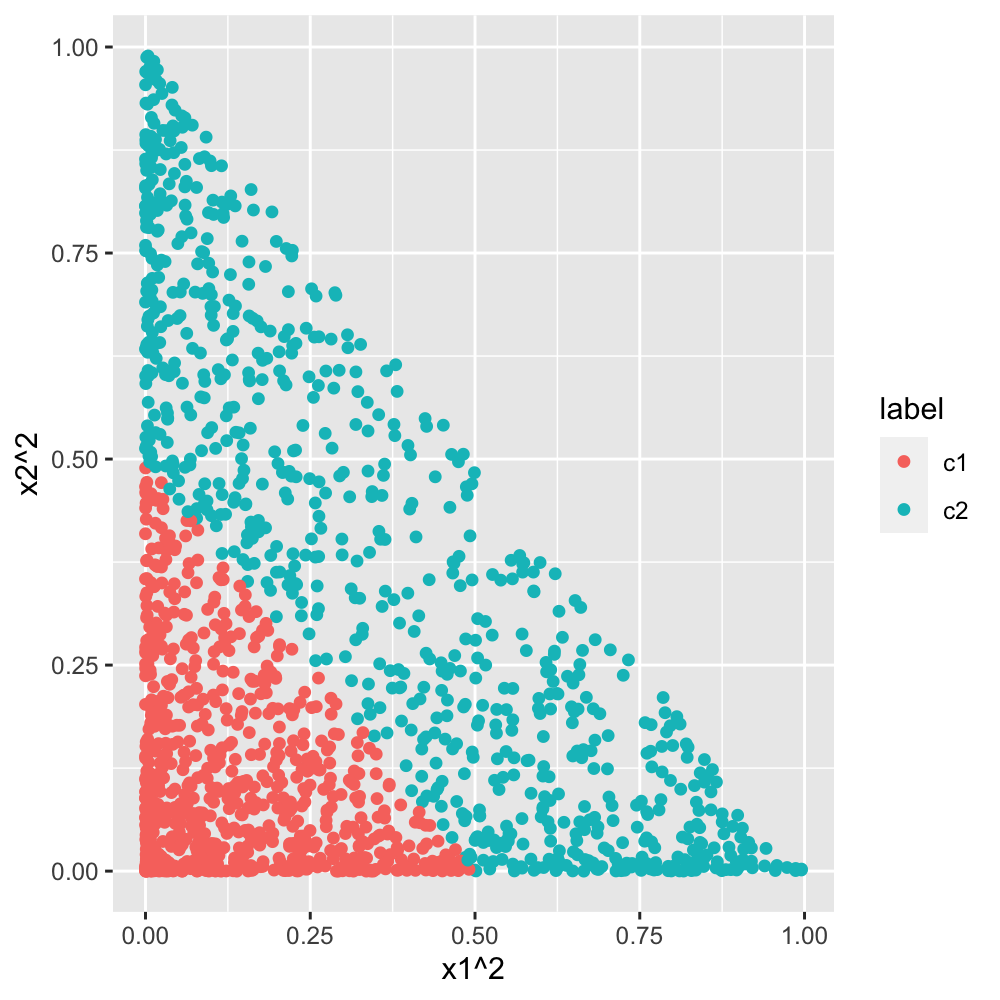

In [9]:
# visualize data after transformation to circular coordinates
ggplot(data, aes(x1^2, x2^2, color = label)) + geom_point()

It is clear we now have a linear decision boundary in the new feature space

In [10]:
# fit another logistic regression model with the transformed features

X = matrix(cbind(1,data$x1^2, data$x2^2), ncol = 3)
Y = matrix(ifelse(data$label == 'c1', 0, 1), ncol = 1)

W_Hat = matrix(runif(3), nrow = 3 , ncol = 1)
eta = 0.0001
epoch_max = 10000
epsilon = 0.001
error = c()
# start gradient descent
for (k in 1:epoch_max){
    error[k] <- loss(X, Y, W_Hat)
    #grad = colSums(matrix(rep((sigmoid(X%*%W_Hat) - Y) , 3), ncol = 3) * X)
    grad = t(X) %*% (sigmoid(X%*%W_Hat) - Y)
    W_old = W_Hat
    W_Hat = W_Hat - eta * grad
    if (abs(max(W_Hat - W_old)) < epsilon){break}
    }

In [11]:
# check for convergence (k < epoch_max)
k

[1] 4395

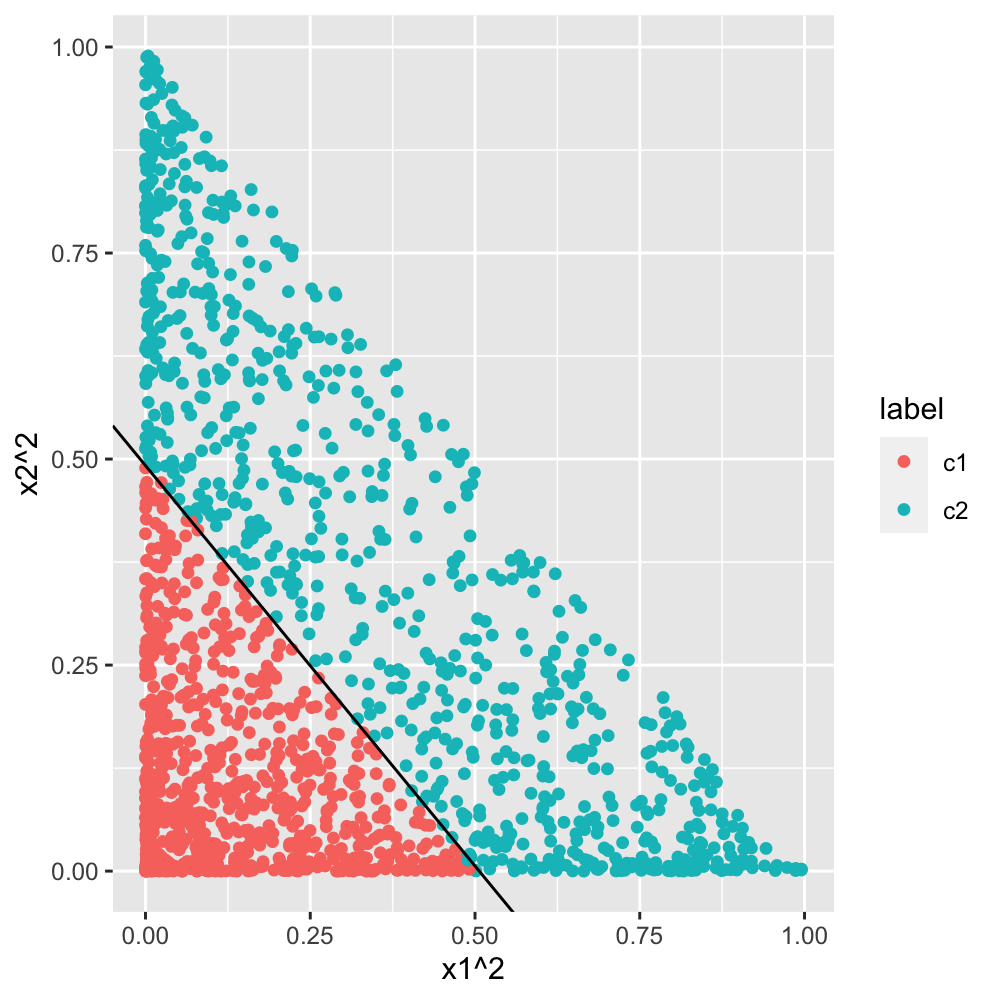

In [12]:
# plot the decision boundary in the new feature space
w0 = W_Hat[1]
w1 = W_Hat[2]
w2 = W_Hat[3]
ggplot(data, aes(x1^2, x2^2, color = label)) + geom_point() + geom_abline(intercept = -w0/w2, slope = -w1/w2)

In [13]:
# check accuracy
accuracy = mean(predict(W_Hat, X) == data$label)
paste('Training Accuracy with feature transformation: ', round(100*accuracy, 2), '%')

[1] "Training Accuracy with feature transformation:  99.62 %"

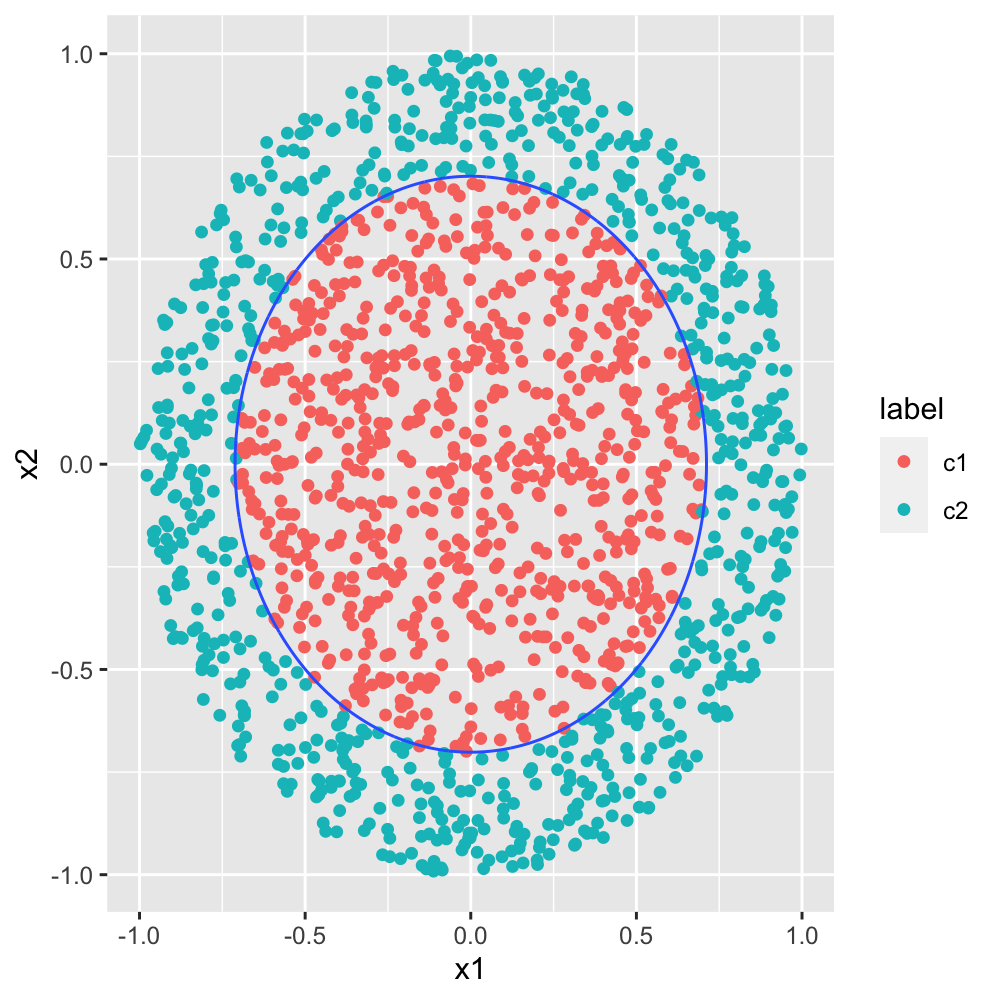

In [14]:
# visualize the decision boundary in the original feature space (see notes below)

grid <- expand.grid(x=seq(-1,1,length = 1000), y=seq(-1,1,length = 1000))
grid <- cbind(1,grid)
grid_trans <- grid^2
prob.grid <- predict(W_Hat, as.matrix(grid_trans), ret_prob = T)
# # plot the boundary
# contour(x=seq(-1,1,length = 1000), y=seq(-1,1,length = 1000), z=matrix(prob.grid, nrow=1000), levels=0.5,
#         col="grey", drawlabels=FALSE, lwd=2)

# points(data[,1:2], col=data$label)


# plot contour at level 0.5 (i.e. decision boundary) overlayed on original points
d_cont = data.frame(grid, prob.grid)
d_cont = round(d_cont, 4)   # rounding is for computational stability 
ggplot(data, aes(x=x1, y=x2) ) + 
    geom_point(aes(col=label)) + 
    geom_contour(data=d_cont, aes(x=x, y=y, z=prob.grid), breaks = c(0.5))

To visualise the decision boundary, we use a contour plot of the 3D plot (x1_grid, x2_grid, prob) where x1_grid and x2_grid is a large grid covering -1 to 1 domain of the x's and prob is the probability of our model prediction for a corresponding pair of x1_grid, x2_grid 

After building the grid, we transform it to the new feature space and obtain our prediction probabilities then we plot the contour of the 3D surface at level = 0.5 (i.e. probability threshold between the two classes)

We then overlay the contour plot with the original data points color coded with their labels

In [29]:
options(warn = oldw)